jupyter nbconvert 4_phenotype_file_generate.ipynb --to script

cd /data/ch6845/MHC*;screen -S assoc;

for i in {0..10};do python 4_association.py $i;done
for i in {00..102};do python 4_pheno_file_generate.py $i;done

In [1]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink

from basic_tools import *

In [2]:
final_aa_path,final_plink_path,final_plink_aa_path

('data/genotype/4_merge/KCHIP_HLA.hg18.intersection_HAN.LABELED.NoSameAllele.bMarkers.2field.saveRareAllele.beagle5.1.AGM.bgl.phased.QC.aa',
 'data/genotype/4_merge/KCHIP_HLA_SNP_1000G_merged',
 'data/genotype/4_merge/KCHIP_HLA_AA_SNP_1000G_merged')

# load plink, aa and check integrity

In [3]:
plink_path=final_plink_path
plink_aa_path=final_plink_aa_path
aa_path=final_aa_path

In [4]:
plink=PyPlink(plink_path)
fam=plink.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
bim=plink.get_bim()

In [5]:
plink_aa=PyPlink(plink_aa_path)
fam_aa=plink_aa.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
bim_aa=plink_aa.get_bim()

In [6]:
assert (fam['IID']!=fam_aa['IID']).sum()==0

In [7]:
f=open(aa_path,'r');aa_ind=f.readline().strip().split(' ')[2:];f.close()

In [8]:
aa_ind_1=[aa_ind[i] for i in range(0,len(aa_ind),2)]
aa_ind_2=[aa_ind[i+1] for i in range(0,len(aa_ind),2)]

In [9]:
assert (fam['IID']!=aa_ind_1).sum()==0
assert (fam['IID']!=aa_ind_2).sum()==0

# load phenotype and check integrity

In [10]:
phenotypes=pd.read_csv(pheno_all_file_path,sep='\t')
'  '.join(phenotypes.columns)

'ID  age  sex  asthma  chronic_bronchitis  allergic_disease  stomach_cancer  liver_cancer  colorectal_cancer  breast_cancer  cervical_cancer  lung_cancer  thyroid_cancer  prostate_cancer  bladder_cancer  colon_polyps  angina_pectoris_myocardial_infarction  hypertension  stroke  transient_ischemic_attacks  acute_liver_disease  diabetes  hyperlipidemia  thyroid_disease  arthritis  rheumatoid_arthritis  osteoporosis  parkinson  pwi_total  chronic_gastritis_stomach_ulcer  duodenal_ulcer  urinary_tract_infection  height  hip_circumference  waist_circumference  weight  systolic_blood_pressure  diastolic_blood_pressure  pulse  hysterectomy  menarche_onset_age  menopause_age  menopause_cycle  ovarian_extraction  child_delivery_number  big_baby  small_baby  child_present  child_dead  hematocrit  hemoglobin  platelet  rbc  wbc  mcv  mch  mchc  total_bilirubin  bun  creatinine  blood_in_urine  glucose_in_urine  alt  ast  gtp  total_cholesterol  hdl_cholesterol  hba1c  freet4  tsh  triglyceride  a

In [11]:
phenotypes=phenotypes.set_index('ID').loc[fam.IID]
phenotypes.shape

(125673, 137)

In [12]:
assert (phenotypes.index!=fam['IID']).sum()==0

In [13]:
binary_traits=phenotypes.columns[phenotypes.apply(lambda x: (not 'x_ray' in x.name) & (len(x.value_counts())<3),axis=0)]
binary_traits,len(binary_traits)

(Index(['sex', 'asthma', 'chronic_bronchitis', 'allergic_disease',
        'stomach_cancer', 'liver_cancer', 'colorectal_cancer', 'breast_cancer',
        'cervical_cancer', 'lung_cancer', 'thyroid_cancer', 'prostate_cancer',
        'bladder_cancer', 'colon_polyps',
        'angina_pectoris_myocardial_infarction', 'hypertension', 'stroke',
        'transient_ischemic_attacks', 'acute_liver_disease', 'diabetes',
        'hyperlipidemia', 'thyroid_disease', 'arthritis',
        'rheumatoid_arthritis', 'osteoporosis', 'parkinson',
        'chronic_gastritis_stomach_ulcer', 'duodenal_ulcer',
        'urinary_tract_infection', 'hysterectomy', 'ovarian_extraction',
        'big_baby', 'small_baby', 'blood_in_urine', 'glucose_in_urine',
        'protein_in_urine', 'heart_failure', 'peripheral_vascular_diseases',
        'cataract', 'glaucoma', 'renal_failure', 'fatty_liver', 'copd',
        'tuberculosis', 'benign_prostatic_hyperplasia', 'gout', 'fracture',
        'cholelithiasis_cholecysti

In [14]:
continuous_traits=phenotypes.columns[phenotypes.apply(lambda x: (not 'x_ray' in x.name) & (len(x.value_counts())>=3),axis=0)]
continuous_traits

Index(['age', 'pwi_total', 'height', 'hip_circumference',
       'waist_circumference', 'weight', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'pulse', 'menarche_onset_age',
       'menopause_age', 'menopause_cycle', 'child_delivery_number',
       'child_present', 'child_dead', 'hematocrit', 'hemoglobin', 'platelet',
       'rbc', 'wbc', 'mcv', 'mch', 'mchc', 'total_bilirubin', 'bun',
       'creatinine', 'alt', 'ast', 'gtp', 'total_cholesterol',
       'hdl_cholesterol', 'hba1c', 'freet4', 'tsh', 'triglyceride', 'albumin',
       'hscrp', 'renin', 'sleep_duration', 'grip_strength', 'ALP',
       'FVC_predicted', 'FEV_predicted', 'FEV_over_FVC_predicted',
       'MVV_predicted', 'bone_density_distal_sos', 'bone_density_midshaft_sos',
       'protein_in_blood', 'glucose_in_blood', 'cohort', 'bmi'],
      dtype='object')

In [15]:
binary_continuous_traits=sorted(binary_traits.union(continuous_traits))
binary_continuous_traits

['ALP',
 'FEV_over_FVC_predicted',
 'FEV_predicted',
 'FVC_predicted',
 'MVV_predicted',
 'acute_liver_disease',
 'age',
 'albumin',
 'allergic_disease',
 'alt',
 'angina_pectoris_myocardial_infarction',
 'arthritis',
 'ast',
 'asthma',
 'benign_prostatic_hyperplasia',
 'big_baby',
 'bladder_cancer',
 'blood_in_urine',
 'bmi',
 'bone_density_distal_sos',
 'bone_density_midshaft_sos',
 'breast_cancer',
 'bun',
 'cataract',
 'cervical_cancer',
 'child_dead',
 'child_delivery_number',
 'child_present',
 'cholelithiasis_cholecystitis',
 'chronic_bronchitis',
 'chronic_gastritis_stomach_ulcer',
 'cohort',
 'colon_polyps',
 'colorectal_cancer',
 'copd',
 'creatinine',
 'diabetes',
 'diastolic_blood_pressure',
 'duodenal_ulcer',
 'fatty_liver',
 'fracture',
 'freet4',
 'glaucoma',
 'glucose_in_blood',
 'glucose_in_urine',
 'gout',
 'grip_strength',
 'gtp',
 'hba1c',
 'hdl_cholesterol',
 'heart_failure',
 'height',
 'hematocrit',
 'hemoglobin',
 'hip_circumference',
 'hscrp',
 'hyperlipidemia'

# parse parameter

In [18]:
if 'ipykernel' in sys.argv[0]:
    ipykernel=True
    phenotype_name='child_dead'
    #phenotype_name='height'
    
else:
    ipykernel=False
    phenotype_name=sys.argv[1]
    if phenotype_name.isdigit():
        phenotype_name=int(phenotype_name)
        phenotype_name=binary_continuous_traits[phenotype_name]

if phenotype_name in binary_traits:
    phenotype_type='binary'
elif phenotype_name in continuous_traits:
    phenotype_type='continuous'        

In [19]:
#data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
#pathlib.Path(data_out_assoc_phenotype_path).mkdir(parents=True, exist_ok=True)

In [16]:
log = logging.getLogger('logger')
log.setLevel(logging.DEBUG)

log_file_name=datetime.datetime.now().strftime('%Y%m%d_%H%M%S')+'.log'
log_file_path=data_out_pheno_path+'4_pheno_file_generate.log'
fileHandler = logging.FileHandler(log_file_path)
streamHandler = logging.StreamHandler()

formatter = logging.Formatter(' %(asctime)s [%(levelname)s] %(lineno)d > %(message)s')
fileHandler.setFormatter(formatter)
streamHandler.setFormatter(formatter)

log.addHandler(fileHandler)
log.addHandler(streamHandler)

In [17]:
log.info("phenotype_name: {}, phenotype_type:{}".format(phenotype_name,phenotype_type))

NameError: name 'phenotype_name' is not defined

 2020-02-28 15:34:47,412 [INFO] 27 > ------------------per cohort---------------------------
 2020-02-28 15:34:47,416 [INFO] 31 > cohort: 1,  3934/ 7607 (51.716%)
 2020-02-28 15:34:47,436 [INFO] 43 > Total values: 3934
 2020-02-28 15:34:47,437 [INFO] 27 > ------------------per cohort---------------------------
 2020-02-28 15:34:47,440 [INFO] 31 > cohort: 2,     0/99159 (0.000%)
 2020-02-28 15:34:47,441 [INFO] 41 > cohort 2 ignored. it may due to nonexistence of questionnaire
 2020-02-28 15:34:47,442 [INFO] 43 > Total values: 3934
 2020-02-28 15:34:47,443 [INFO] 27 > ------------------per cohort---------------------------
 2020-02-28 15:34:47,446 [INFO] 31 > cohort: 3,     0/18907 (0.000%)
 2020-02-28 15:34:47,447 [INFO] 41 > cohort 3 ignored. it may due to nonexistence of questionnaire
 2020-02-28 15:34:47,448 [INFO] 43 > Total values: 3934
 2020-02-28 15:34:47,455 [INFO] 49 > median:0.000, mean: 0.101, std: 0.392, max: 4.000, min: 0.000
/home/ch6845/tools/miniconda3/envs/pytorch/lib/p

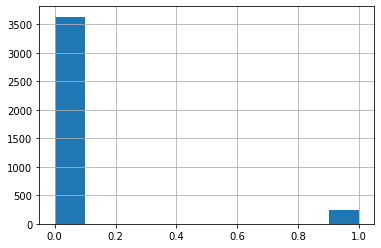

In [22]:
phenotype_define=np.full(len(phenotypes.index),np.nan)

if phenotype_type=='binary':
    for cohort in sorted(phenotypes['cohort'].unique()):
        log.info('------------------per cohort---------------------------')
        cohort_check=(phenotypes['cohort']==cohort)
        cohort_case_check=(phenotypes['cohort']==cohort)&(phenotypes[phenotype_name]==2)
        cohort_control_check=(phenotypes['cohort']==cohort)&(~(phenotypes[phenotype_name]==2))
        log.info('cohort: {}, {:5d}/{:5d} ({:.3f}%)'.format(cohort,cohort_case_check.sum(),cohort_check.sum(),100*cohort_case_check.sum()/cohort_check.sum()))

        if cohort_case_check.sum()>0:
            phenotype_define[cohort_case_check]=2
            phenotype_define[cohort_control_check]=1
        elif np.isnan(cohort):
            raise
            cohort_check_temp=(phenotypes['cohort'].isnull())
            phenotype_define[cohort_check_temp]=-9
            log.info('missing individuals founded: {}'.format(cohort_check_temp.sum()))
        else:
            log.info('cohort {} ignored. it may due to nonexistence of questionnaire'.format(cohort))

        log.info('Total case:'+str((phenotype_define==2).sum()))
    log.info("phenotype defined\n"+str(pd.Series(phenotype_define).value_counts()))
    
elif phenotype_type=='continuous':
    for cohort in sorted(phenotypes['cohort'].unique()):
        log.info('------------------per cohort---------------------------')
        cohort_check=(phenotypes['cohort']==cohort)
        cohort_notnull_check=(phenotypes['cohort']==cohort)&(~(phenotypes[phenotype_name].isnull()))
        #print(cohort_notnull_check,type(cohort_notnull_check))
        log.info('cohort: {}, {:5d}/{:5d} ({:.3f}%)'.format(cohort,cohort_notnull_check.sum(),cohort_check.sum(),100*cohort_notnull_check.sum()/cohort_check.sum()))

        if cohort_notnull_check.sum()>0:
            phenotype_define[cohort_notnull_check]=phenotypes[phenotype_name][cohort_notnull_check]
        elif np.isnan(cohort):
            raise
            cohort_check_temp=(phenotypes['cohort'].isnull())
            phenotype_define[cohort_check_temp]=-9
            log.info('missing individuals founded: {}'.format(cohort_check_temp.sum()))
        else:
            log.info('cohort {} ignored. it may due to nonexistence of questionnaire'.format(cohort))

        log.info('Total values: {}'.format((~np.isnan(phenotype_define)).sum()))
    
    log.info("median:{:.3f}, mean: {:.3f}, std: {:.3f}, max: {:.3f}, min: {:.3f}".format(pd.Series(phenotype_define).median(),
                                                         pd.Series(phenotype_define).mean(),
                                                         pd.Series(phenotype_define).std(),
                                                         pd.Series(phenotype_define).max(),
                                                         pd.Series(phenotype_define).min()
                                                        )
         )
    if phenotype_name!='child_dead':
        log.info(">mean+3std:{}, <mean-3std:{}".format((phenotype_define>(pd.Series(phenotype_define).mean()+3*pd.Series(phenotype_define).std())).sum(),
                                                    (phenotype_define<(pd.Series(phenotype_define).mean()-3*pd.Series(phenotype_define).std())).sum()
                                                   )
             )
        phenotype_define[phenotype_define>(pd.Series(phenotype_define).mean()+3*pd.Series(phenotype_define).std())]=np.nan
        phenotype_define[phenotype_define<(pd.Series(phenotype_define).mean()-3*pd.Series(phenotype_define).std())]=np.nan
    
    log.info('Total values: {}'.format((~np.isnan(phenotype_define)).sum()))                                                  
    pd.Series(phenotype_define).hist()

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6708789/
    
age, gender, race, diabetes, hyperlipidemia, hypertension, and all significant alleles.



phenotypes[]
union 
* diabetes
* hyperlipidemia
* hypertension
* allergic_disease
* colon polyps
* rheumatoid_arthritis

-> unhealthy individuals -> if overlap with case-> set as missing

In [23]:
if phenotype_type=='binary' and phenotype_name!='sex':
    unhealthy_individuals=(phenotypes['diabetes']==2)|\
                            (phenotypes['hyperlipidemia']==2)|\
                            (phenotypes['hypertension']==2)|\
                            (phenotypes['allergic_disease']==2)|\
                            (phenotypes['colon_polyps']==2)|\
                            (phenotypes['rheumatoid_arthritis']==2)
    log.info("unhealthy individuals: {}".format(unhealthy_individuals.sum()))
    log.info("unhealthy individuals among control removed: {}".format(((phenotype_define==1) & (unhealthy_individuals)).sum()))
    phenotype_define[(phenotype_define==1) & (unhealthy_individuals)]=np.nan
    ## change to np.nan and test!!
    log.info("phenotype defined\n"+str(pd.Series(phenotype_define).value_counts()))

In [24]:
if phenotype_type=='binary':
    if phenotype_name=='breast_cancer' or phenotype_name=='cervical_cancer':
        log.info('exclude men: {}'.format(((~np.isnan(phenotype_define))&(phenotypes['sex']==1)).sum()))
        phenotype_define[(~np.isnan(phenotype_define))&(phenotypes['sex']==1)]=np.nan
        log.info("phenotype defined\n"+str(pd.Series(phenotype_define).value_counts()))
    elif phenotype_name=='prostate_cancer':
        log.info('exclude women: {}'.format(((~np.isnan(phenotype_define))&(phenotypes['sex']==2)).sum()))
        phenotype_define[(~np.isnan(phenotype_define))&(phenotypes['sex']==2)]=np.nan
        log.info("phenotype defined\n"+str(pd.Series(phenotype_define).value_counts()))

In [33]:
#np.unique(phenotype_define)

In [25]:
phenotype_define_df=pd.DataFrame(phenotype_define,index=phenotypes.index)

phenotype_define_df=phenotype_define_df.loc[fam['IID']].fillna(-9)

if phenotype_name in binary_traits:
    phenotype_define_df=phenotype_define_df.astype(int)
    
phenotype_define_df_noindex=phenotype_define_df.reset_index().rename(columns={0:'pheno'})

phenotype_define_df_noindex[[phenotype_define_df_noindex.columns[0],phenotype_define_df_noindex.columns[0],phenotype_define_df_noindex.columns[1]]].to_csv(pheno_file_path.format(phenotype_name),index=None,header=None,sep='\t')


#phenotype_define_df_noindex[[phenotype_define_df_noindex.columns[0],phenotype_define_df_noindex.columns[0],phenotype_define_df_noindex.columns[1]]].to_csv(data_out_assoc_phenotype_path+'phenotype.pheomnibus',index=None,sep='\t')

In [26]:
phenotype_define_df_noindex.shape

(125673, 2)

In [27]:
assert (phenotype_define_df_noindex['pheno']==np.nan).sum()==0
if phenotype_type=='binary':
    log.info(phenotype_define_df_noindex['pheno'].value_counts())
elif phenotype_type=='continuous':
    log.info(phenotype_define_df_noindex['pheno'].value_counts().iloc[:5])
    log.info('...')
    log.info(phenotype_define_df_noindex['pheno'].value_counts().iloc[-5:])
else:
    raise

 2020-02-28 15:35:07,332 [INFO] 5 > -9.0    121807
 0.0      3631
 1.0       235
Name: pheno, dtype: int64
 2020-02-28 15:35:07,334 [INFO] 6 > ...
 2020-02-28 15:35:07,338 [INFO] 7 > -9.0    121807
 0.0      3631
 1.0       235
Name: pheno, dtype: int64
